# Predict sex from brain rhythms :

*by Dreem*

**GROUPE : Mehdi FERHAT, Yasmine OUYAHYA, Amira SLIMENE.**

In [6]:
from google.colab import drive,files
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/My Drive/Deep

/content/drive/My Drive/Deep


# Import des packages

In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import time

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score,classification_report,roc_curve, auc, roc_auc_score

import tensorflow
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.layers as layers

import warnings
warnings.filterwarnings('ignore')

# Load files :

In [28]:
import os
os.getcwd()

y_train = pd.read_csv(os.getcwd() + '/y_train_AvCsavx.csv', index_col=False)
X_train = h5py.File(os.getcwd() + '/X_train_new.h5', 'r')
X_test = h5py.File(os.getcwd() + '/X_test_new.h5', 'r')

In [29]:
print(X_train.keys(), X_test.keys())

<KeysViewHDF5 ['features']> <KeysViewHDF5 ['features']>


On extrait les features.

In [30]:
X_train = X_train['features']
X_test = X_test['features']

**Description du dataset** : Pour chaque individu donné Xi (avec i = 1, .... , 946), on a 40 x 7 x 500
informations.
40 segments, 7 électroencephalogramme (zones cérébrales), 500 correspond à 2 secondes d’onde échantillonné à 250Hz = soit 500 points pour chaque segment de chaque électroencephalogramme d'un individu.

In [31]:
print(X_train.shape, X_test.shape, y_train.shape)

(946, 40, 7, 500) (946, 40, 7, 500) (946, 2)


In [32]:
X_train = np.array(X_train)
X_test = np.array(X_test)

print('X train shape: ', X_train.shape)
print('X_test_shape', X_test.shape)

X train shape:  (946, 40, 7, 500)
X_test_shape (946, 40, 7, 500)


Pour ce qui est de la target ``label`` on peut déjà remarquer un problème de déséquilibre qui pourrait poser problème. Avec une surreprésentation des individus hommes.

In [33]:
y_train['label'].value_counts()

0    737
1    209
Name: label, dtype: int64

# Représentation graphiques

In [ ]:
labels = ['Male', 'Female']
fig = go.Figure()
fig.add_trace(go.Pie(labels=labels, values=y_train['label'].value_counts()))
fig.update_traces(text =labels, textinfo = 'percent+text')
fig.update_layout(title_text = "Gender distribution", title_x = 0.5)
fig.update_traces(marker=dict(colors=["#0064FF","#FF8FDF"]))
fig.show()

Par exemple ici on va afficher l'activité cérébrale d'un seul individu au premier segment d'enregistrement de 2 secondes (en tout chaque individu est mesuré pour 40 segments soit 80sec) pour chaque région du cerveau (correspondant à un électroencephalogramme representés par une courbe).

On peut remarquer que les électroencephalogramme semblent fonctionner par paire, positionnés à des régions assez proches elles retournent pratiquement la même information, sauf pour le 7ème qui est vraisemblalement isolé.

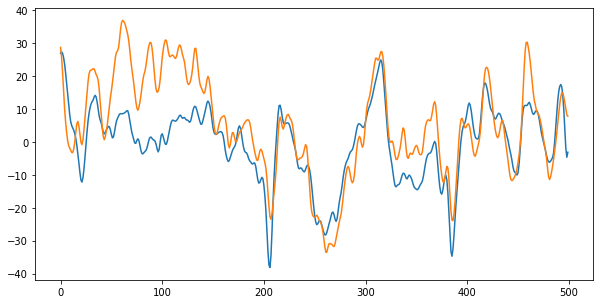

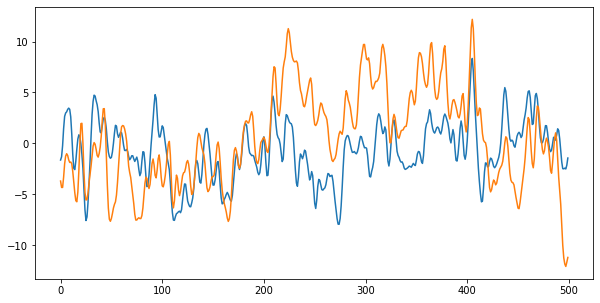

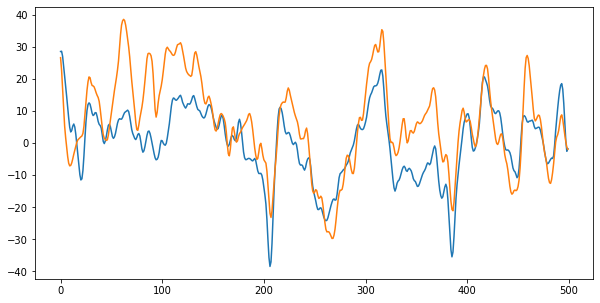

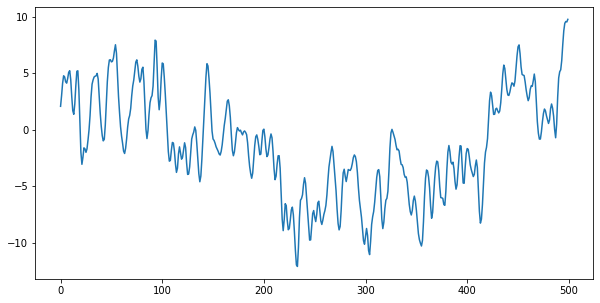

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(X_train[0][0][0])
plt.plot(X_train[0][0][1])

plt.figure(figsize=(10,5))
plt.plot(X_train[0][0][2])
plt.plot(X_train[0][0][3])

plt.figure(figsize=(10,5))
plt.plot(X_train[0][0][4])
plt.plot(X_train[0][0][5])

plt.figure(figsize=(10,5))
plt.plot(X_train[0][0][6])

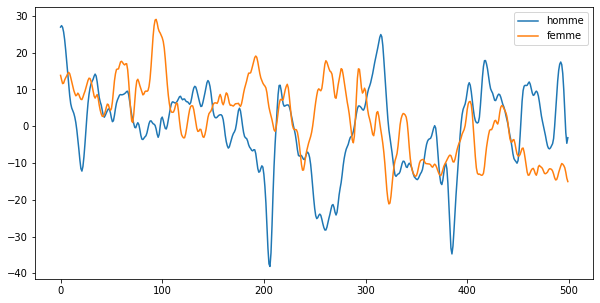

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(X_train[0][0][0], label='homme')
plt.plot(X_train[8][0][0], label='femme')
plt.legend()

In [ ]:
def eeg_plot(x):
  
    """
    Permet de visualiser l'activité des 7 canaux (électroencephalogrammes)
    pour un individu et un segment donné.
    
    Paramètres
    ----------
    x : 4D Array

    Returns
    ----------
    The plot

    """
    n_channels=7

    fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True)

    for n in range(n_channels):
        ax = axs[n // 4, n % 4]
        ax.set_title('Channel ' + str(n+1))
        ax.set(xlabel='time (sec)')
        abscisse = np.linspace(0, 10, 500)

        for i in range(len(x)):
          #i number of samples and n number of segments
            ax.plot(x[i][n])    
    fig.delaxes(axs[1][3])
    plt.show()

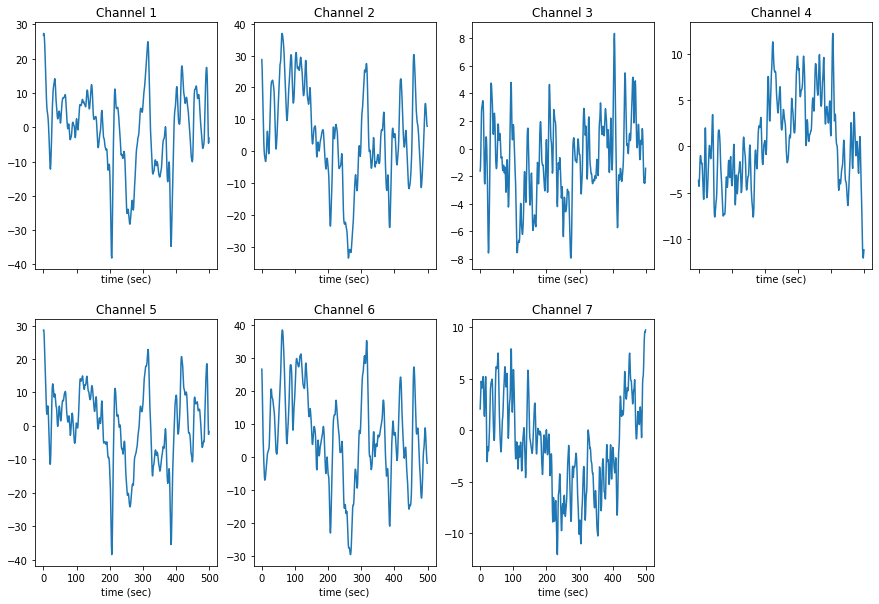

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
eeg_plot([X_train[0, 0]])

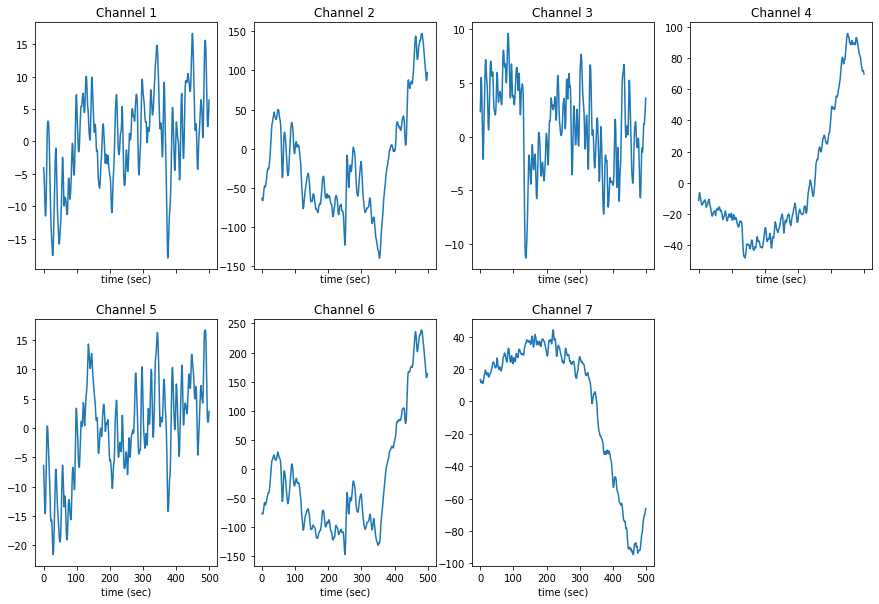

In [ ]:
eeg_plot([X_train[945, 39]])

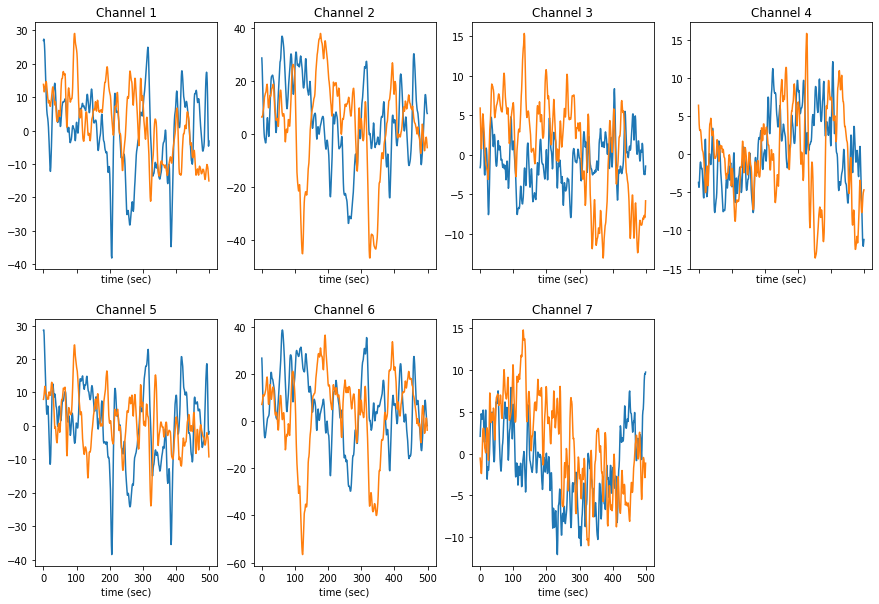

In [ ]:
eeg_plot([X_train[0, 0], X_train[8,0]])

# Preprocessing:

In [34]:
def preprocessing(dataset):

    """
    Transforme la matrice d'entrée pour obtenir le min,max,moyenne et moyenne absolue
    de chaque segment. Réencode l'id pour obtenir 40*7 observations par individu et one
    hot encoding de chaque segment et canal.
    
    Paramètres
    ----------
    dataset : 4D Array

    Returns
    ----------
    df : pandas dataframe

    """
       
    dataset = np.array(dataset)
    dataset = dataset.reshape(946*40*7,500)
    
    columns=[[],[],[],[]]
    for i in range(946*40*7):
        columns[0]+=[min(dataset[i])]
        columns[1]+=[max(dataset[i])]
        columns[2]+=[np.mean(dataset[i])]
        columns[3]+=[np.mean(abs(dataset[i]))]
        
    df = pd.DataFrame(columns)
    df = df.T
    
    Canal = list(range(1,8)) * 37840
    Segment = list(range(1,41)) * 6622
    Id = [i for i in range(946) for _ in range(280)]
    
    df['id'] = Id
    df['Canal'] = Canal
    df['Segment'] = Segment
    
    df.columns = ['minimum','maximum','moyenne','moyenne_abs','id','canal','segment']
    df = pd.get_dummies(df,columns=["segment","canal"])
    
    return df

In [35]:
def export_pred(y_pred,csv=True):
    
    """
    Transformation des prédictions pour qu'elles correspondent au format
    de soumission sur le site du challenge. Sur fenêtre de 280 (chaque individu)
    on va récupérer le mode càd la prédiction du sexe la plus retournée pour
    chaque segment * canal ainsi que l'id correspondant.
    
    Paramètres
    ----------
    y_pred : pandas dataframe

    Returns
    ----------
    mode : pandas dataframe
    y_pred.csv : fichier csv de soumission

    """
    mode=[]
    for i in range(0,264880,280):
        mode.append(round(y_pred['y_pred'][i:280+i].mode()[0]))
    mode = pd.DataFrame(mode)
    Id = [i for i in range(946) for _ in range(1)]
    mode['id'] = Id
    mode.columns = ['label','id']
    columnsTitles = ['id', 'label']
    mode = mode.reindex(columns=columnsTitles)
    if csv==True:
        mode.to_csv("y_pred.csv", index=False)
    return mode

On a applique donc la fonction de preprocessing à notre jeu de données de train et de test pour pouvoir effectuer les prédictions.

In [36]:
X_train = preprocessing(X_train)
X_train = X_train.merge(y_train, how='inner', on='id')

X_train.head()

,minimum,maximum,moyenne,moyenne_abs,id,segment_1,segment_2,segment_3,segment_4,segment_5,...,segment_39,segment_40,canal_1,canal_2,canal_3,canal_4,canal_5,canal_6,canal_7,label
0,-38.144482,27.372673,-0.589931,9.004287,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,-33.561211,36.967400,5.130957,12.493910,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,-7.939834,8.339167,-0.775626,2.356103,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,-12.075249,12.175351,0.578525,3.805783,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,-38.437092,28.684286,0.185735,8.935882,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [37]:
X_test = preprocessing(X_test)
X_test.head()

,minimum,maximum,moyenne,moyenne_abs,id,segment_1,segment_2,segment_3,segment_4,segment_5,...,segment_38,segment_39,segment_40,canal_1,canal_2,canal_3,canal_4,canal_5,canal_6,canal_7
0,-21.150175,27.903336,0.448327,10.469664,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,-15.404159,41.409653,7.570618,11.288608,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,-11.414134,24.223034,9.219040,10.354882,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,-17.190834,35.423222,1.045834,9.913220,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,-33.037571,25.811659,-8.770665,13.266357,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
print(X_train.shape, X_test.shape)

(264880, 53) (946, 40, 7, 500)


# Machine Learning models: 

## Local tests:

On va tout d'abord centrer-réduire les variables pour les transformer en unités compatibles avec distribution de moyenne 0 et d'écart-type 1, indépendantes de leurs distributions et unités de mesures originales.

In [38]:
sc=StandardScaler() 
X_train.iloc[:,0:4]=sc.fit_transform(X_train.iloc[:,0:4]) 
X_test.iloc[:,0:4]=sc.transform(X_test.iloc[:,0:4])

In [ ]:
mean = X_train.iloc[:,0:4].mean()
std = X_train.iloc[:,0:4].std()

temp = pd.DataFrame([mean,std], index=['mean','std'])
temp

,minimum,maximum,moyenne,moyenne_abs
mean,-2.142154e-10,-1.061795e-10,1.744363e-10,-1.013086e-10
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00


In [ ]:
target = X_train["label"]
data = X_train.drop(['id','label'],axis=1)

X_TRAIN_SPLIT, X_TEST_SPLIT, Y_TRAIN_SPLIT, Y_TEST_SPLIT = train_test_split(data, target, test_size=0.2)

In [ ]:
def grid_search(model, X_train, y_train):

  """
  Effectue un GridSearchCV avec des paramètres prédéfinis pour le modèle
  sélectionné.
  
  Paramètres
  ----------
  model : str, nom du modèle
  X_train
  y_train

  Returns
  ----------
  
  Les meilleurs paramètres avec le score associé et le temps d'exécution.

  """

  if model == "RandomForestClassifier":
        estimator =RandomForestClassifier(class_weight='balanced', random_state=42)
        print("RandomForestClassifier")
        print("------")
        params = {"n_estimators":list(range(50, 200, 50)), 
                  'max_depth':list(range(5, 30, 10))}

        gs = GridSearchCV(estimator,
              param_grid=params,
              scoring="accuracy",
              return_train_score=True,
              cv = 5,
              n_jobs=-1)
        
        t1 = time.time()

        gs.fit(X_train, y_train)
        results = gs.cv_results_

        t2 = time.time() - t1
        
  if model == "XGBClassifier":
        estimator = XGBClassifier(objective='binary:logistic', random_state=42) 
        print("XGBClassifier")
        print("------")
        params = {"n_estimators":[100, 150],
                  "learning_rate": [0.05, 0.1],
                  "max_depth": [5, 10]}

        gs = GridSearchCV(estimator,
              param_grid=params,
              scoring="accuracy", 
              return_train_score=True,
              cv = 5,
              n_jobs=-1)
        
        t1 = time.time()

        gs.fit(X_train, y_train)
        results = gs.cv_results_

        t2 = time.time() - t1
    
  if model == "DecisionTreeClassifier":
        estimator = DecisionTreeClassifier(random_state=42)
        print("DecisionTreeClassifier")
        print("------")
        params = {'max_depth':list(range(5, 50, 10)),
                  'criterion': ['entropy', 'gini']}
    
        gs = GridSearchCV(estimator,
              param_grid=params,
              scoring="accuracy", 
              return_train_score=True,
              cv = 5, 
              n_jobs=-1)
        
        t1 = time.time()
        gs.fit(X_train, y_train)
        results = gs.cv_results_
        t2 = time.time() - t1
        
  if model == "GradientBoostingClassifier":
        estimator = GradientBoostingClassifier(random_state=42)
        print("GradientBoostingClassifier")
        print("------")
        params = {'n_estimators': list(range(50, 100, 30)),
                  'learning_rate': [0.05, 0.1]}
                  
        gs = GridSearchCV(estimator,
              param_grid=params,
              scoring="accuracy", return_train_score=True, 
              cv = 5,
              n_jobs=-1)
        
        t1 = time.time()
        gs.fit(X_train, y_train)
        results = gs.cv_results_
        t2 = time.time() - t1

  print("L'opération a pris %.2fs" %t2)
  print("Les meilleurs paramètres sont:", gs.best_params_)
  print("Le meilleur score est: %.2f" %gs.best_score_)

  return 

In [ ]:
grid_search("RandomForestClassifier", X_TRAIN_SPLIT, Y_TRAIN_SPLIT)

RandomForestClassifier
------
L'opération a pris 1071.39s
Les meilleurs paramètres sont: {'max_depth': 25, 'n_estimators': 150}
Le meilleur score est: 0.74


In [ ]:
grid_search("XGBClassifier", X_TRAIN_SPLIT, Y_TRAIN_SPLIT)

XGBClassifier
------
L'opération a pris 1455.59s
Les meilleurs paramètres sont: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Le meilleur score est: 0.78


In [ ]:
grid_search("DecisionTreeClassifier", X_TRAIN_SPLIT, Y_TRAIN_SPLIT)

DecisionTreeClassifier
------
L'opération a pris 82.02s
Les meilleurs paramètres sont: {'criterion': 'entropy', 'max_depth': 5}
Le meilleur score est: 0.78


In [ ]:
grid_search("GradientBoostingClassifier", X_TRAIN_SPLIT, Y_TRAIN_SPLIT)

GradientBoostingClassifier
------
L'opération a pris 288.36s
Les meilleurs paramètres sont: {'learning_rate': 0.05, 'n_estimators': 50}
Le meilleur score est: 0.78


On utilise les meilleurs paramètres récupérés avec le GridSearch:



In [ ]:
def plot_confusion_matrix(y, y_pred):
  """
  Effectue un plot de la matrice de confusion d'un modèle.
  
  Paramètres
  ----------
  y : y_test
  y_pred

  Returns
  ----------
  La matrice de confusion correspondante.
  """
  matrix = confusion_matrix(y, y_pred)
  group_names = ['Vrai negatifs','Faux positifs','Faux negatifs','Vrai positifs']
  group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in matrix.flatten()/np.sum(matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
  plt.show()

RandomForestClassifier
----------------------


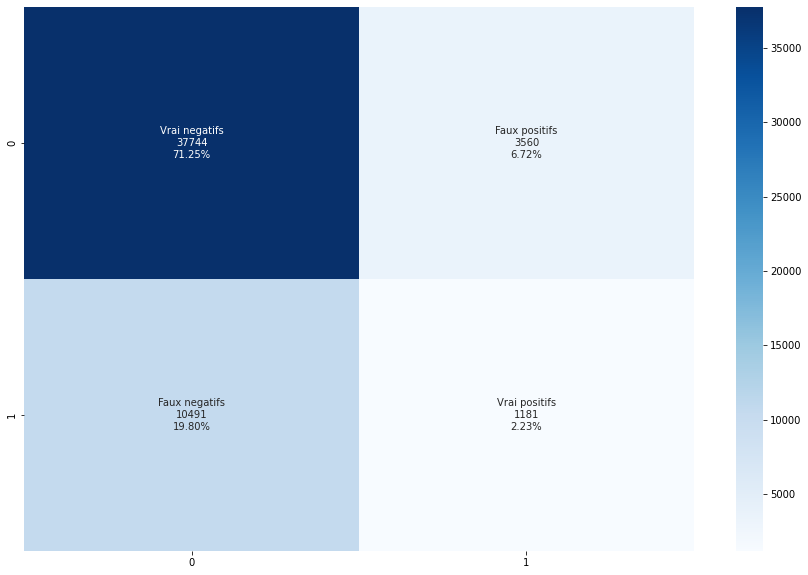

----------------------
              precision    recall  f1-score   support

           0       0.78      0.91      0.84     41304
           1       0.25      0.10      0.14     11672

    accuracy                           0.73     52976
   macro avg       0.52      0.51      0.49     52976
weighted avg       0.66      0.73      0.69     52976

----------------------


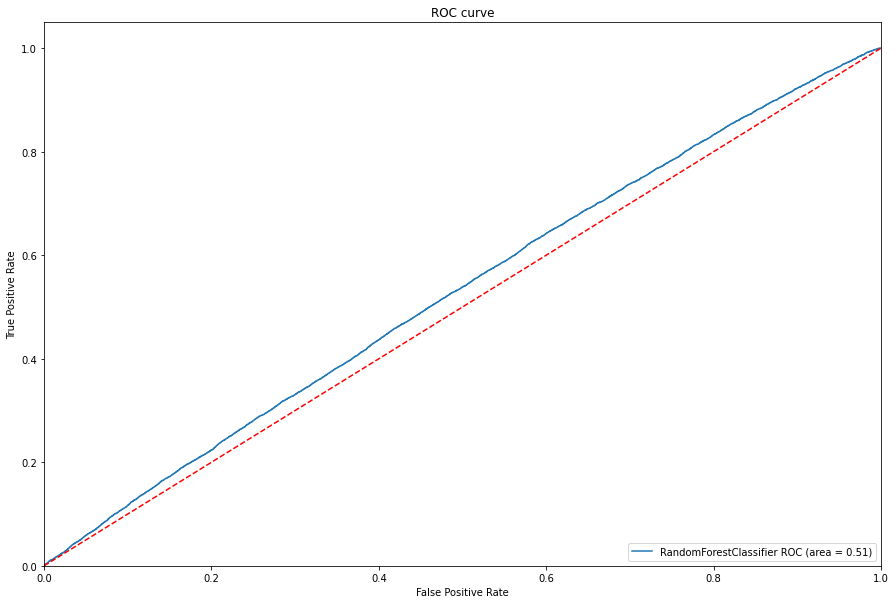

RandomForestClassifier
----------------------


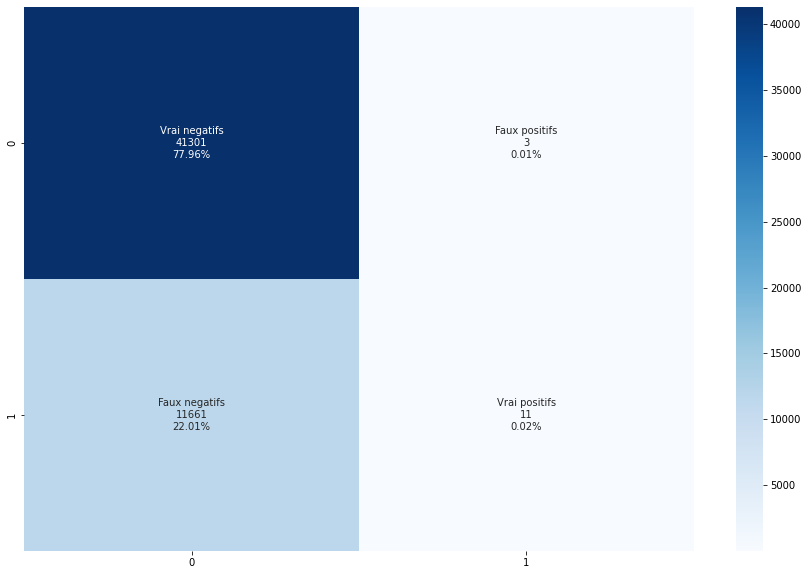

----------------------
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     41304
           1       0.79      0.00      0.00     11672

    accuracy                           0.78     52976
   macro avg       0.78      0.50      0.44     52976
weighted avg       0.78      0.78      0.68     52976

----------------------


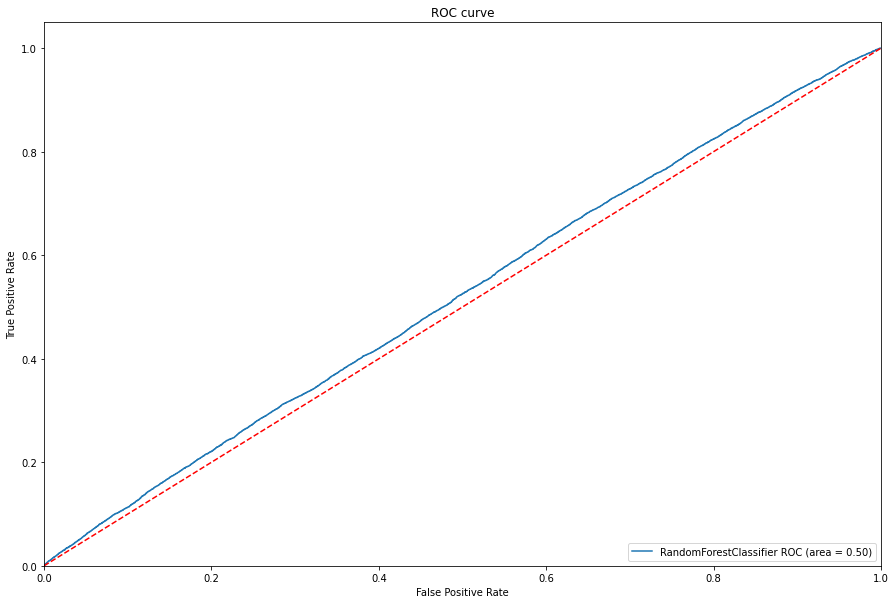

XGBClassifier
----------------------


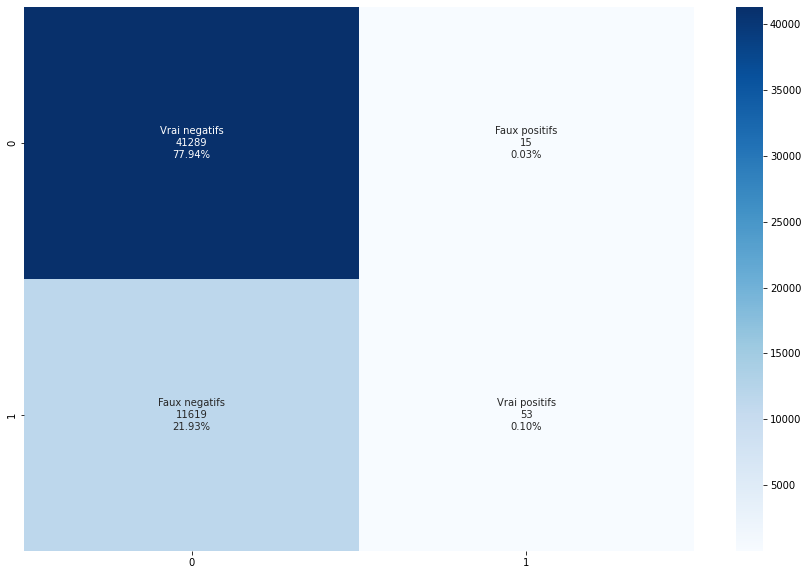

----------------------
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     41304
           1       0.78      0.00      0.01     11672

    accuracy                           0.78     52976
   macro avg       0.78      0.50      0.44     52976
weighted avg       0.78      0.78      0.69     52976

----------------------


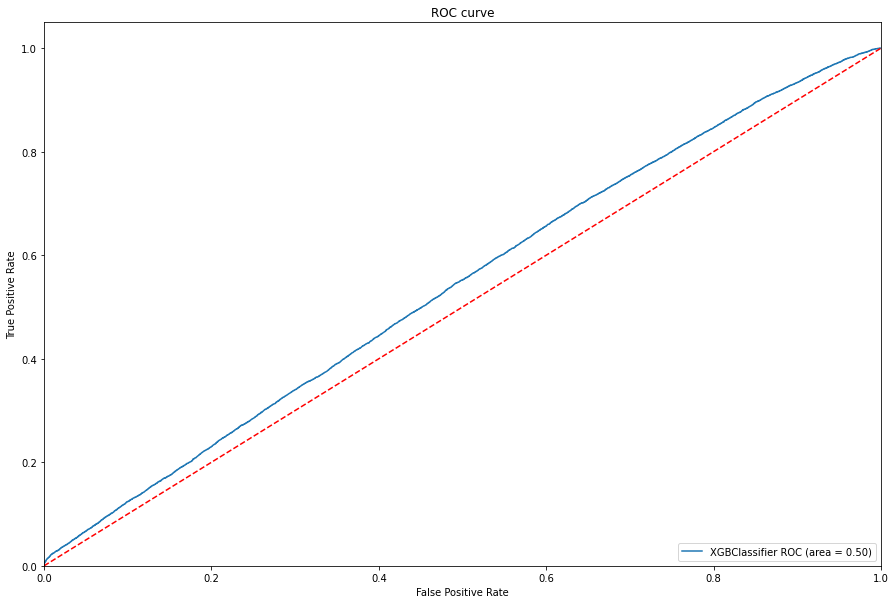

DecisionTreeClassifier
----------------------


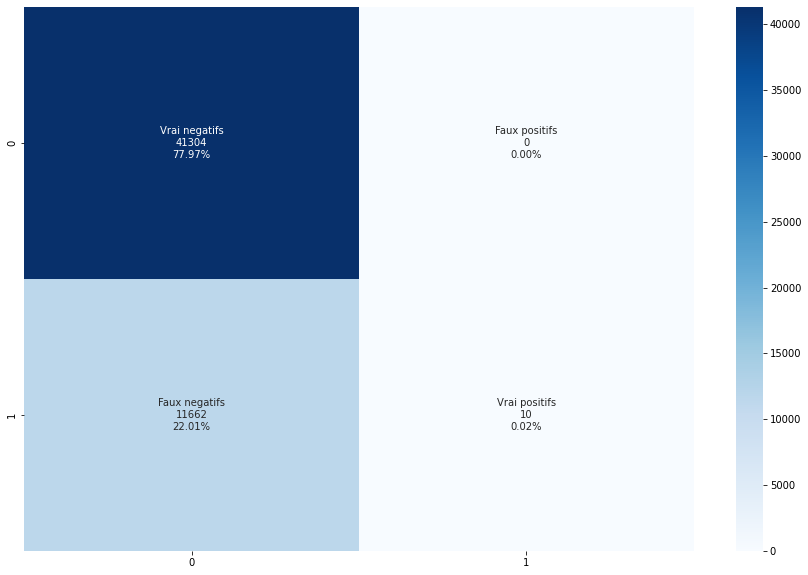

----------------------
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     41304
           1       1.00      0.00      0.00     11672

    accuracy                           0.78     52976
   macro avg       0.89      0.50      0.44     52976
weighted avg       0.83      0.78      0.68     52976

----------------------


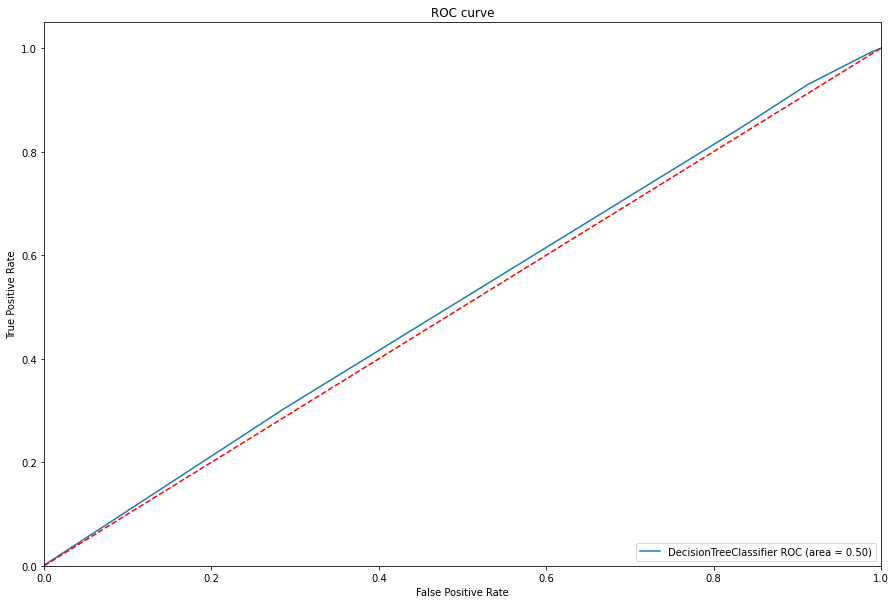

GradientBoostingClassifier
----------------------


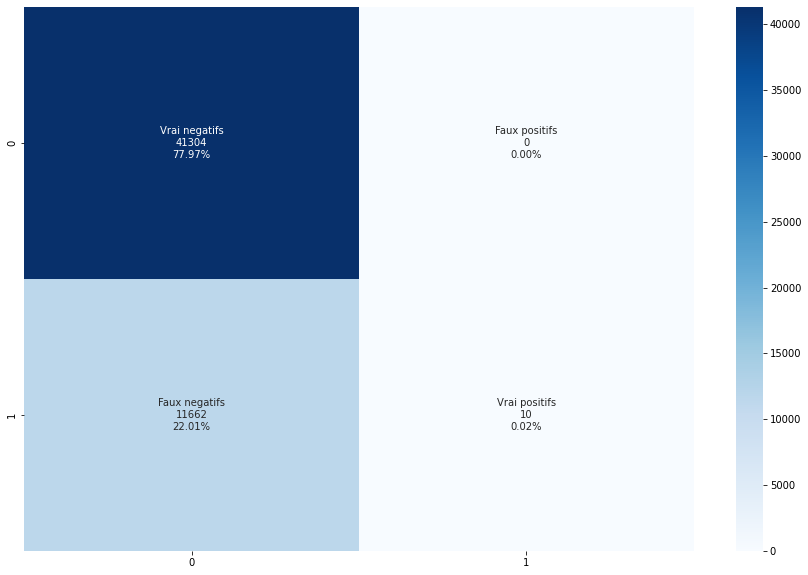

----------------------
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     41304
           1       1.00      0.00      0.00     11672

    accuracy                           0.78     52976
   macro avg       0.89      0.50      0.44     52976
weighted avg       0.83      0.78      0.68     52976

----------------------


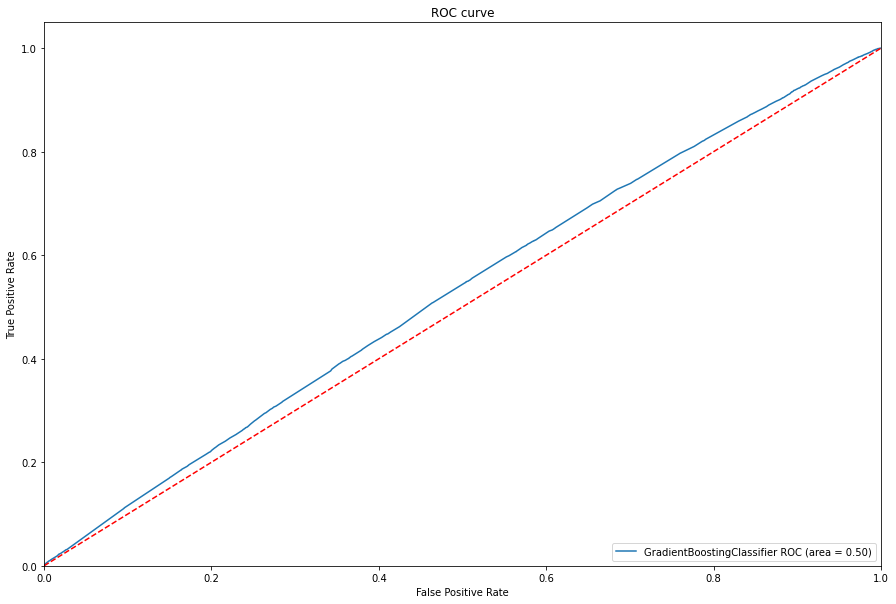

In [ ]:
classifiers = [
      RandomForestClassifier(max_depth= 25, n_estimators= 150, class_weight='balanced', random_state=42),
      RandomForestClassifier(max_depth= 25, n_estimators= 150, random_state=42),
      XGBClassifier(objective= 'binary:logistic',learning_rate= 0.1, max_depth= 10, n_estimators =100, random_state=42),
      DecisionTreeClassifier(criterion='entropy', max_depth = 5, random_state=42),
      GradientBoostingClassifier(learning_rate= 0.05, n_estimators= 50, random_state=42)]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_TRAIN_SPLIT,Y_TRAIN_SPLIT)
    y_pred = clf.predict(X_TEST_SPLIT)
    print(name)
    print("----------------------")
    plot_confusion_matrix(Y_TEST_SPLIT, y_pred)
    print("----------------------")
    print(classification_report(Y_TEST_SPLIT, y_pred))
    print("----------------------")
    
    fpr, tpr, thresholds =roc_curve(Y_TEST_SPLIT, clf.predict_proba(X_TEST_SPLIT)[:,1])
    auc = roc_auc_score(Y_TEST_SPLIT,clf.predict(X_TEST_SPLIT))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
    
    result_table = result_table.append({'classifiers':clf.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()   
    
    
result_table.set_index('classifiers', inplace=True)

----------------------


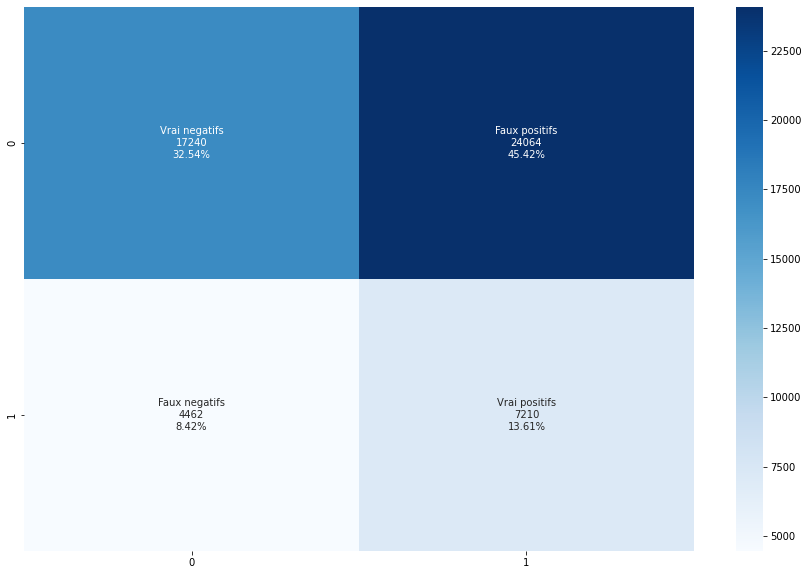

----------------------
              precision    recall  f1-score   support

           0       0.79      0.42      0.55     41304
           1       0.23      0.62      0.34     11672

    accuracy                           0.46     52976
   macro avg       0.51      0.52      0.44     52976
weighted avg       0.67      0.46      0.50     52976

----------------------
L'accuracy score est de 0.46


In [ ]:
clf1 = RandomForestClassifier(max_depth= 25, n_estimators= 150, class_weight='balanced', random_state=42)
clf2 = RandomForestClassifier(max_depth= 25, n_estimators= 150, random_state=42)
clf3 = XGBClassifier(objective= 'binary:logistic',learning_rate= 0.1, max_depth= 10, n_estimators =100, random_state=42)
clf4 = DecisionTreeClassifier(criterion='entropy', max_depth = 5, random_state=42)
clf5 = GradientBoostingClassifier(learning_rate= 0.05, n_estimators= 50, random_state=42)

estimators=[('rf_balance_weights', clf1), ('rf', clf2), ('xgb', clf3), ('dt', clf4), ('gb', clf5)]

#VotingClassifier:
vclf = VotingClassifier(estimators, voting='soft')
vclf.fit(X_TRAIN_SPLIT,Y_TRAIN_SPLIT)
y_pred = clf.predict(X_TEST_SPLIT)
print("----------------------")
plot_confusion_matrix(Y_TEST_SPLIT, y_pred)
print("----------------------")
print(classification_report(Y_TEST_SPLIT, y_pred))
print("----------------------")
accuracy_score_ = accuracy_score(Y_TEST_SPLIT, y_pred)
print("L'accuracy score est de %.2f" %accuracy_score_)

## Méthodes d'undersampling et oversampling pour prendre en compte le déséquilibre de classe.

## SMOTE

SMOTE (pour Synthetic Minority Oversampling Technique) est une technique qui génère des données synthétiques pour la classe minoritaire. SMOTE fonctionne en choisissant au hasard un point de la classe minoritaire et en calculant les k voisins les plus proches de ce point. Les points synthétiques sont ajoutés entre le point choisi et ses voisins.

On effectue donc un oversampling avec la méthode SMOTE, on remarque le f1-score de la classe 'femme' s'est certes amélioré mais au détriment du score général et de la classe 'homme'.

SMOTE
--------
RandomForestClassifier
----------------------


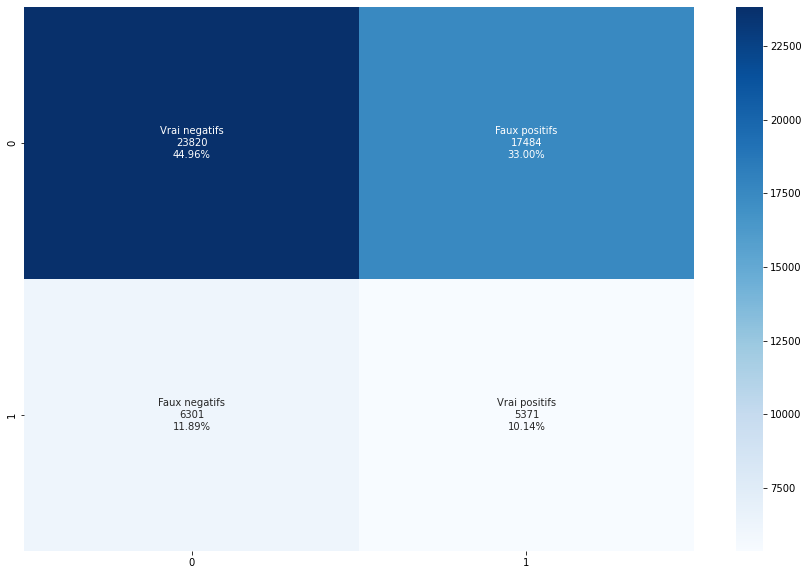

----------------------
              precision    recall  f1-score   support

           0       0.79      0.58      0.67     41304
           1       0.24      0.46      0.31     11672

    accuracy                           0.55     52976
   macro avg       0.51      0.52      0.49     52976
weighted avg       0.67      0.55      0.59     52976

----------------------


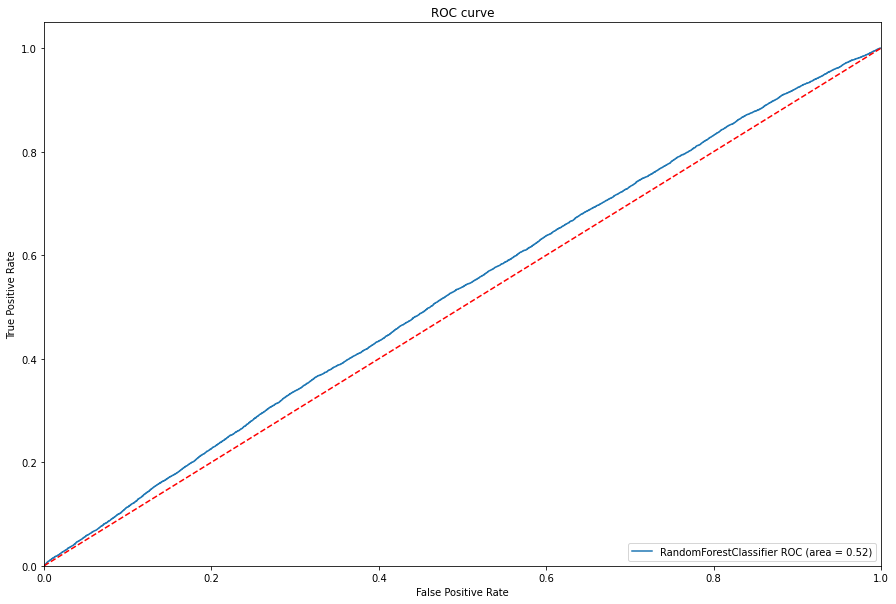

RandomForestClassifier
----------------------


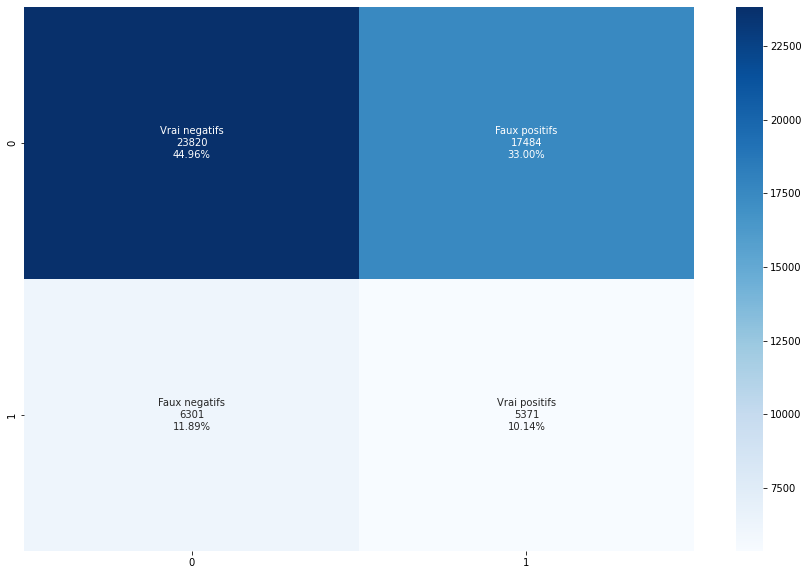

----------------------
              precision    recall  f1-score   support

           0       0.79      0.58      0.67     41304
           1       0.24      0.46      0.31     11672

    accuracy                           0.55     52976
   macro avg       0.51      0.52      0.49     52976
weighted avg       0.67      0.55      0.59     52976

----------------------


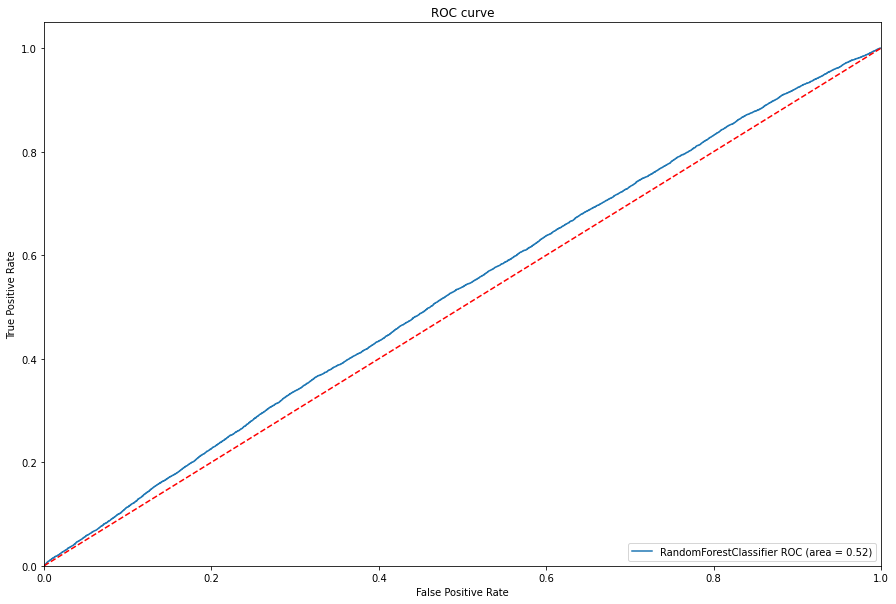

XGBClassifier
----------------------


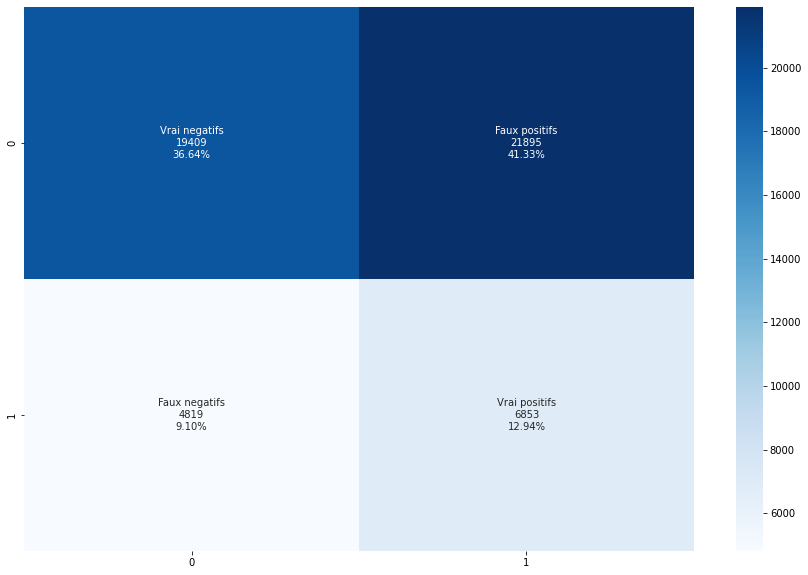

----------------------
              precision    recall  f1-score   support

           0       0.80      0.47      0.59     41304
           1       0.24      0.59      0.34     11672

    accuracy                           0.50     52976
   macro avg       0.52      0.53      0.47     52976
weighted avg       0.68      0.50      0.54     52976

----------------------


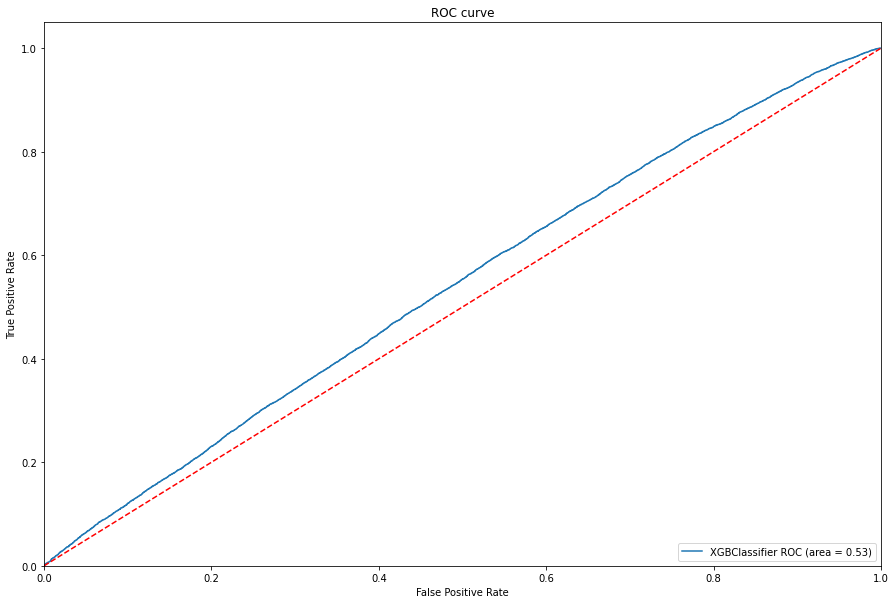

DecisionTreeClassifier
----------------------


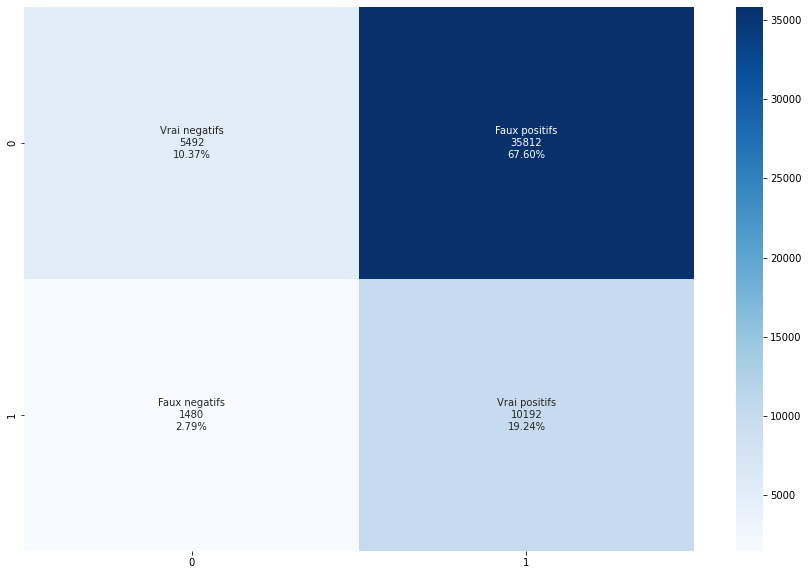

----------------------
              precision    recall  f1-score   support

           0       0.79      0.13      0.23     41304
           1       0.22      0.87      0.35     11672

    accuracy                           0.30     52976
   macro avg       0.50      0.50      0.29     52976
weighted avg       0.66      0.30      0.26     52976

----------------------


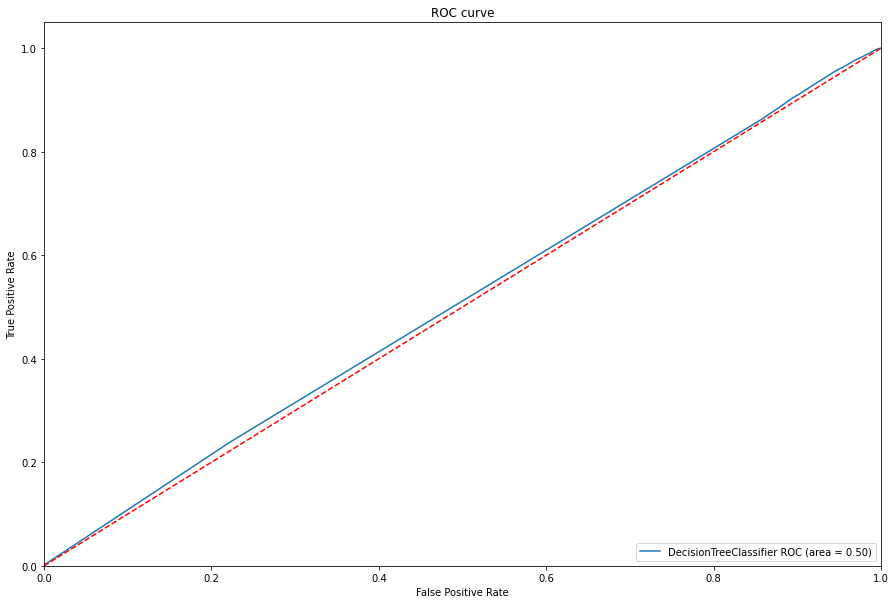

GradientBoostingClassifier
----------------------


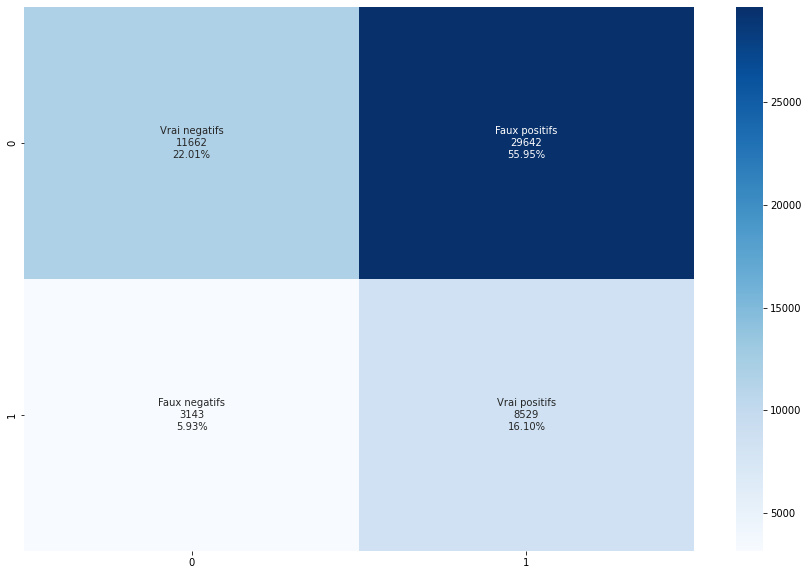

----------------------
              precision    recall  f1-score   support

           0       0.79      0.28      0.42     41304
           1       0.22      0.73      0.34     11672

    accuracy                           0.38     52976
   macro avg       0.51      0.51      0.38     52976
weighted avg       0.66      0.38      0.40     52976

----------------------


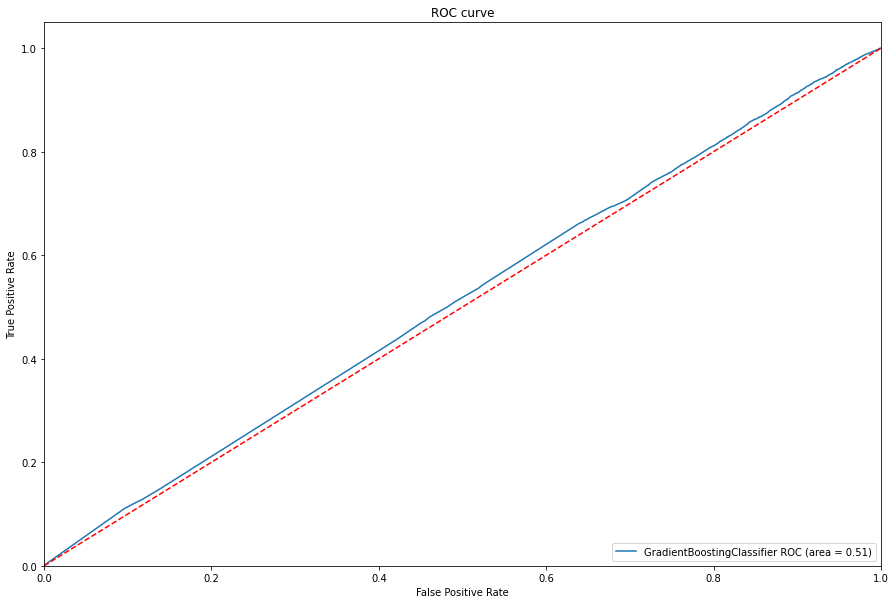

In [ ]:
classifiers = [
      RandomForestClassifier(max_depth= 25, n_estimators= 150, class_weight='balanced', random_state=42),
      RandomForestClassifier(max_depth= 25, n_estimators= 150, random_state=42),
      XGBClassifier(objective= 'binary:logistic',learning_rate= 0.1, max_depth= 10, n_estimators =100, random_state=42),
      DecisionTreeClassifier(criterion='entropy', max_depth = 5, random_state=42),
      GradientBoostingClassifier(learning_rate= 0.05, n_estimators= 50, random_state=42)]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

print("SMOTE")
print("--------")
smote = SMOTE(random_state=42 , k_neighbors=15)
X_TRAIN_SPLIT_sm, Y_TRAIN_SPLIT_sm = smote.fit_resample(X_TRAIN_SPLIT, Y_TRAIN_SPLIT)

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_TRAIN_SPLIT_sm, Y_TRAIN_SPLIT_sm)
    y_pred = clf.predict(X_TEST_SPLIT)
    print(name)
    print("----------------------")
    plot_confusion_matrix(Y_TEST_SPLIT, y_pred)
    print("----------------------")
    print(classification_report(Y_TEST_SPLIT, y_pred))
    print("----------------------")
    
    fpr, tpr, thresholds =roc_curve(Y_TEST_SPLIT, clf.predict_proba(X_TEST_SPLIT)[:,1])
    auc = roc_auc_score(Y_TEST_SPLIT,clf.predict(X_TEST_SPLIT))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
    
    result_table = result_table.append({'classifiers':clf.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()   
    
    
result_table.set_index('classifiers', inplace=True)

# Méthode d'undersampling

RandomUnderSampler
--------
RandomForestClassifier
----------------------


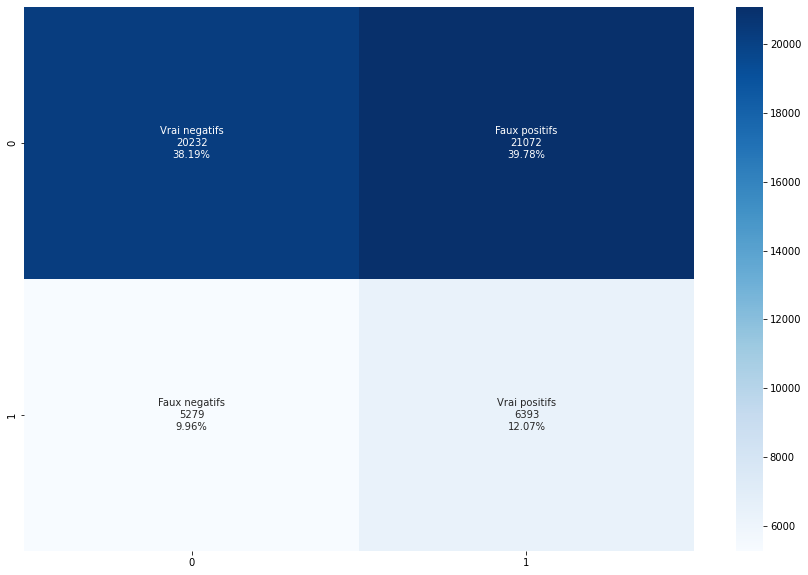

----------------------
              precision    recall  f1-score   support

           0       0.79      0.49      0.61     41304
           1       0.23      0.55      0.33     11672

    accuracy                           0.50     52976
   macro avg       0.51      0.52      0.47     52976
weighted avg       0.67      0.50      0.54     52976

----------------------


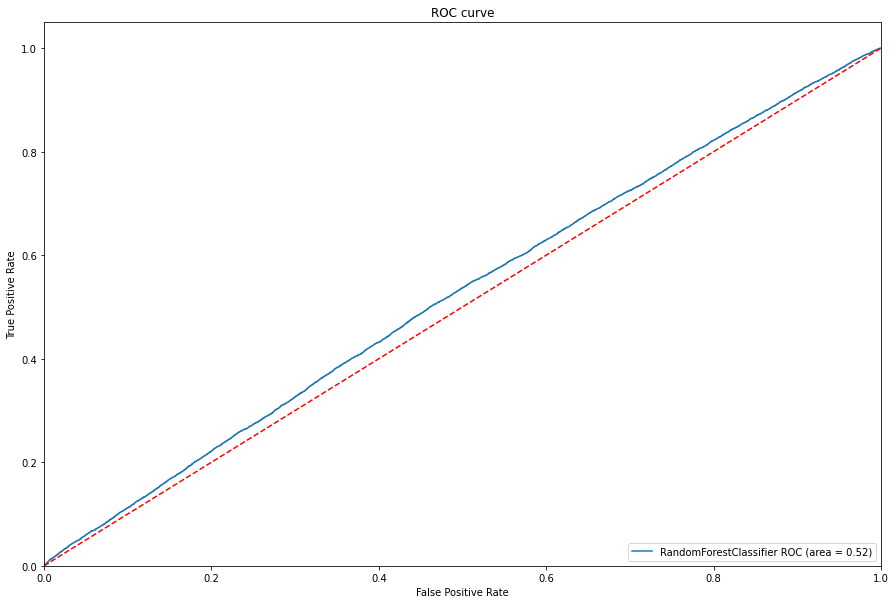

RandomForestClassifier
----------------------


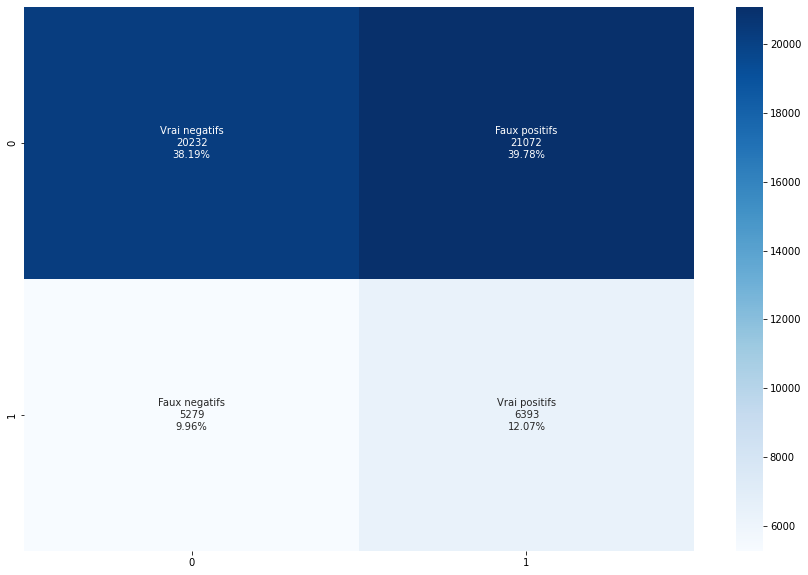

----------------------
              precision    recall  f1-score   support

           0       0.79      0.49      0.61     41304
           1       0.23      0.55      0.33     11672

    accuracy                           0.50     52976
   macro avg       0.51      0.52      0.47     52976
weighted avg       0.67      0.50      0.54     52976

----------------------


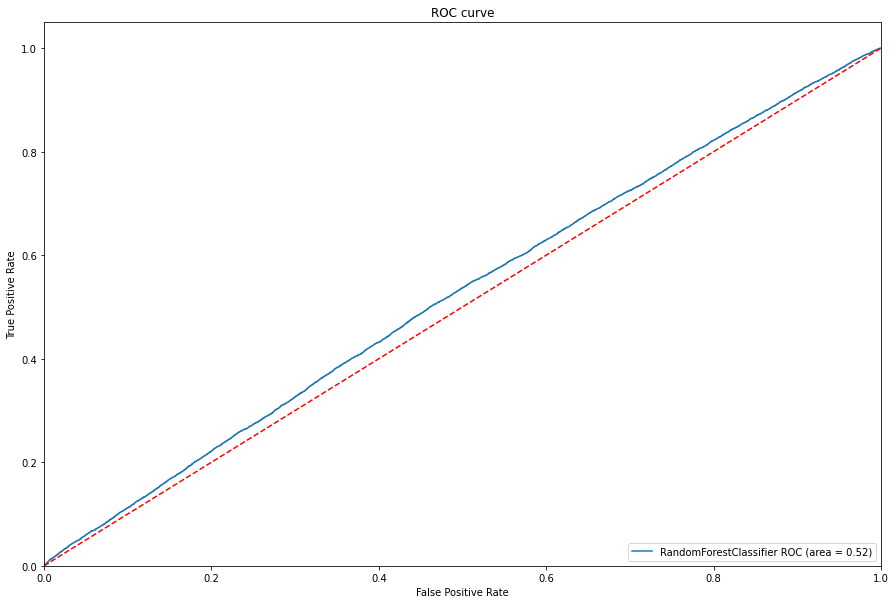

XGBClassifier
----------------------


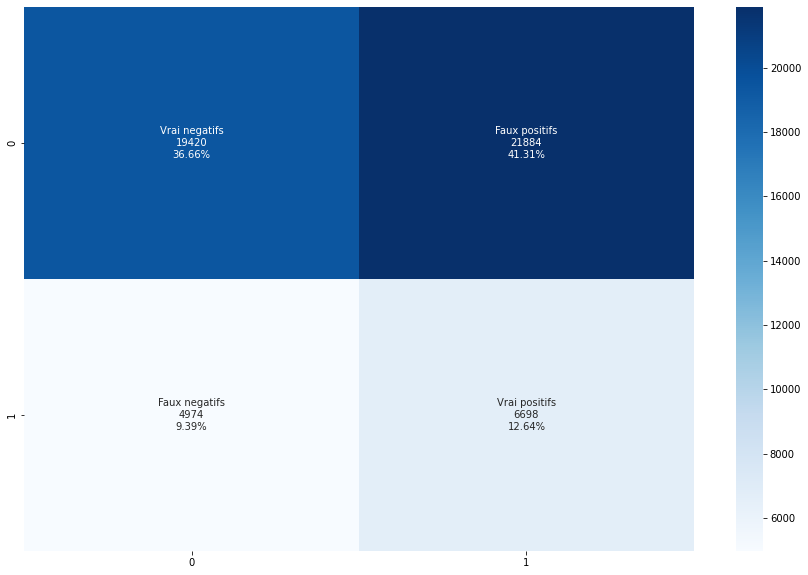

----------------------
              precision    recall  f1-score   support

           0       0.80      0.47      0.59     41304
           1       0.23      0.57      0.33     11672

    accuracy                           0.49     52976
   macro avg       0.52      0.52      0.46     52976
weighted avg       0.67      0.49      0.53     52976

----------------------


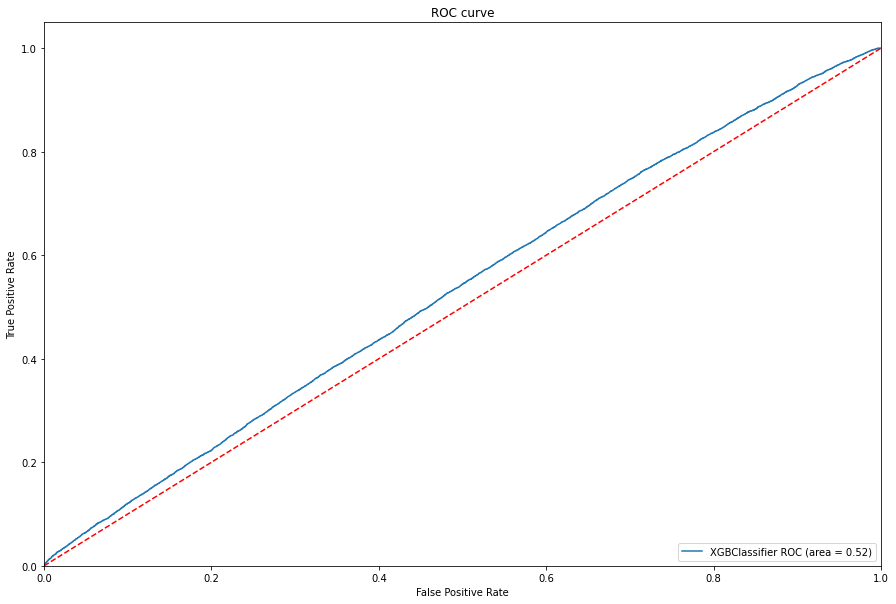

DecisionTreeClassifier
----------------------


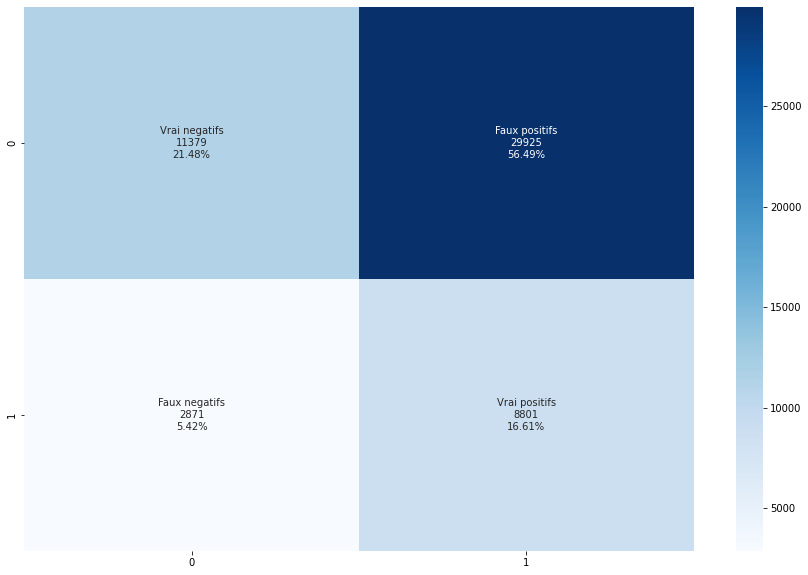

----------------------
              precision    recall  f1-score   support

           0       0.80      0.28      0.41     41304
           1       0.23      0.75      0.35     11672

    accuracy                           0.38     52976
   macro avg       0.51      0.51      0.38     52976
weighted avg       0.67      0.38      0.40     52976

----------------------


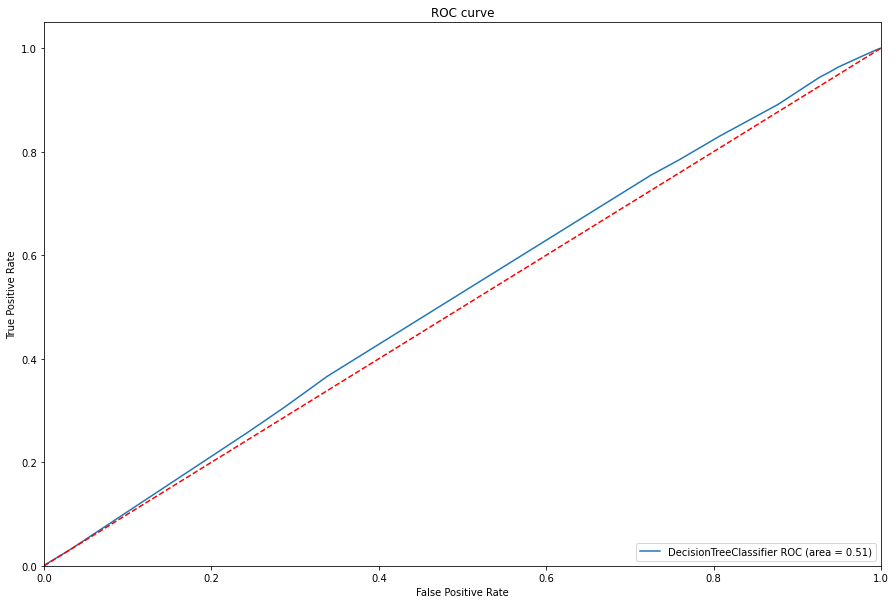

GradientBoostingClassifier
----------------------


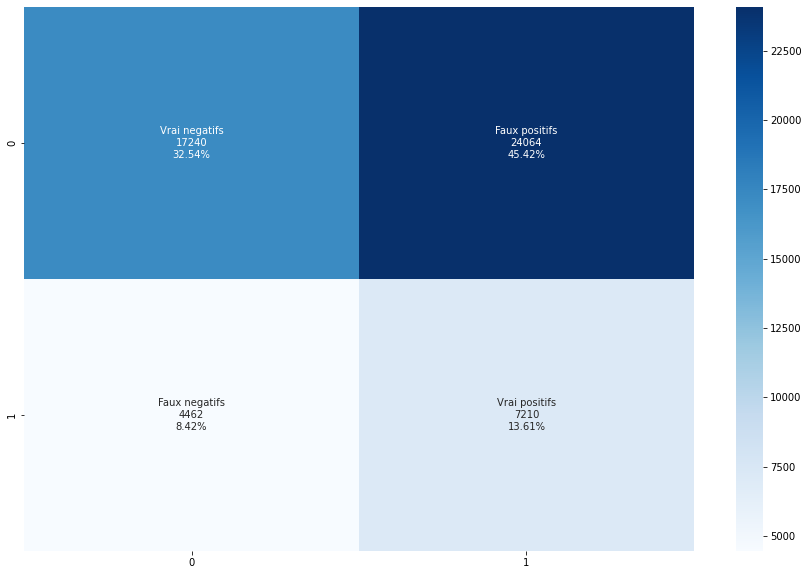

----------------------
              precision    recall  f1-score   support

           0       0.79      0.42      0.55     41304
           1       0.23      0.62      0.34     11672

    accuracy                           0.46     52976
   macro avg       0.51      0.52      0.44     52976
weighted avg       0.67      0.46      0.50     52976

----------------------


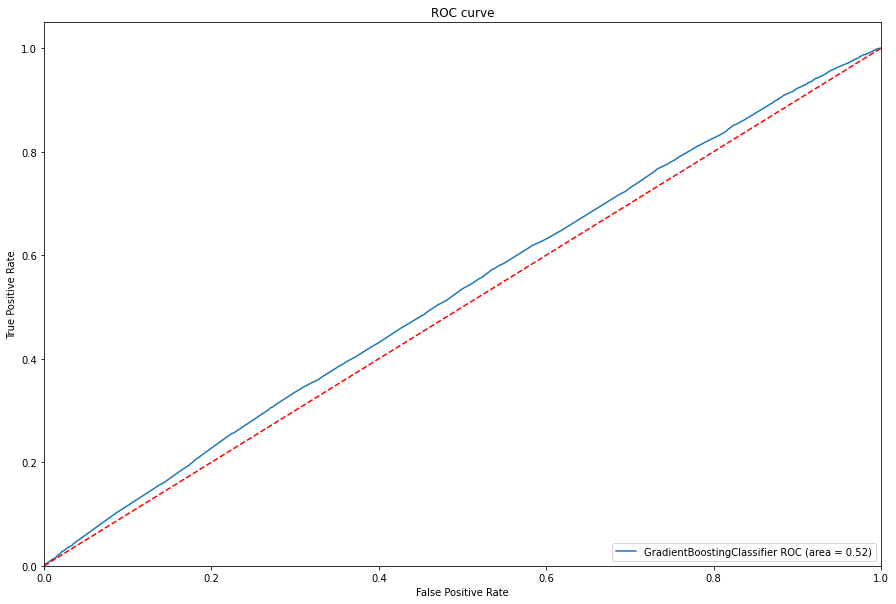

In [ ]:
classifiers = [
      RandomForestClassifier(max_depth= 25, n_estimators= 150, class_weight='balanced', random_state=42),
      RandomForestClassifier(max_depth= 25, n_estimators= 150, random_state=42),
      XGBClassifier(objective= 'binary:logistic',learning_rate= 0.1, max_depth= 10, n_estimators =100, random_state=42),
      DecisionTreeClassifier(criterion='entropy', max_depth = 5, random_state=42),
      GradientBoostingClassifier(learning_rate= 0.05, n_estimators= 50, random_state=42)]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

print("RandomUnderSampler")
print("--------")
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_TRAIN_SPLIT_rus , Y_TRAIN_SPLIT_rus = rus.fit_resample(X_TRAIN_SPLIT, Y_TRAIN_SPLIT)

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_TRAIN_SPLIT_rus , Y_TRAIN_SPLIT_rus)
    y_pred = clf.predict(X_TEST_SPLIT)
    print(name)
    print("----------------------")
    plot_confusion_matrix(Y_TEST_SPLIT, y_pred)
    print("----------------------")
    print(classification_report(Y_TEST_SPLIT, y_pred))
    print("----------------------")
    
    fpr, tpr, thresholds =roc_curve(Y_TEST_SPLIT, clf.predict_proba(X_TEST_SPLIT)[:,1])
    auc = roc_auc_score(Y_TEST_SPLIT,clf.predict(X_TEST_SPLIT))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
    
    result_table = result_table.append({'classifiers':clf.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()   
    
    
result_table.set_index('classifiers', inplace=True)

# CNN (Nature):

In [8]:
import os
os.getcwd()

y_train = pd.read_csv(os.getcwd() + '/y_train_AvCsavx.csv', index_col=False)
train = h5py.File(os.getcwd() + '/X_train_new.h5', 'r')
test = h5py.File(os.getcwd() + '/X_test_new.h5', 'r')

train = train['features']
test = test['features']

In [9]:
test_train = np.array(train)
test_test = np.array(test)
test_y = np.array(y_train['label'])

In [10]:
test_train = test_train.reshape(946,40,500,7)
test_test = test_test.reshape(946,40,500,7)

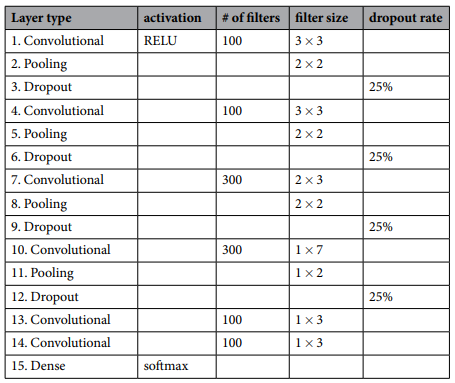

In [22]:
optimizer = tensorflow.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e08)
loss = tensorflow.keras.losses.BinaryCrossentropy()

In [23]:
model = tensorflow.keras.models.Sequential([tensorflow.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation='relu',
                                                                          input_shape=(40,500,7)),
                                            
                        tensorflow.keras.layers.AveragePooling2D(pool_size=(2, 2)),
                                            
                        tensorflow.keras.layers.Dropout(rate=0.25),
                                            
                        tensorflow.keras.layers.Conv2D(filters=100,kernel_size=(3, 3)),
                                            
                        tensorflow.keras.layers.AveragePooling2D(pool_size=(2, 2)),
                                            
                        tensorflow.keras.layers.Dropout(rate=0.25),
                                            
                        tensorflow.keras.layers.Conv2D(filters=300, kernel_size=(3, 3)),
                                            
                        tensorflow.keras.layers.AveragePooling2D(pool_size=(2, 2)),
                                            
                        tensorflow.keras.layers.Dropout(rate=0.25),
                                            
                        tensorflow.keras.layers.Conv2D(filters=300, kernel_size=(1, 7)),
                                            
                        tensorflow.keras.layers.AveragePooling2D(pool_size=(1, 2)),
                                            
                        tensorflow.keras.layers.Dropout(rate=0.25),

                        tensorflow.keras.layers.Conv2D(filters=100, kernel_size=(1, 3)),
                                            
                        tensorflow.keras.layers.Conv2D(filters=100, kernel_size=(1, 3)),

                        tensorflow.keras.layers.Flatten(),
                                            
                        tensorflow.keras.layers.Dense(units=1, activation='softmax')])

model.compile(loss=loss, 
          optimizer=optimizer,
          metrics=['accuracy']) 

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 38, 498, 100)      6400      
                                                                 
 average_pooling2d_12 (Avera  (None, 19, 249, 100)     0         
 gePooling2D)                                                    
                                                                 
 dropout_12 (Dropout)        (None, 19, 249, 100)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 17, 247, 100)      90100     
                                                                 
 average_pooling2d_13 (Avera  (None, 8, 123, 100)      0         
 gePooling2D)                                                    
                                                                 
 dropout_13 (Dropout)        (None, 8, 123, 100)      

In [25]:
model.fit(test_train, test_y, epochs=40, batch_size=100)

Epoch 1/40
10/10 [==============================] - 5s 409ms/step - loss: 49.1765 - accuracy: 0.2209
Epoch 2/40
10/10 [==============================] - 4s 412ms/step - loss: 36.9431 - accuracy: 0.2209
Epoch 3/40
10/10 [==============================] - 4s 411ms/step - loss: 49.7086 - accuracy: 0.2209
Epoch 4/40
10/10 [==============================] - 4s 412ms/step - loss: 37.4704 - accuracy: 0.2209
Epoch 5/40
10/10 [==============================] - 4s 410ms/step - loss: 63.0713 - accuracy: 0.2209
Epoch 6/40
10/10 [==============================] - 4s 411ms/step - loss: 43.3592 - accuracy: 0.2209
Epoch 7/40
10/10 [==============================] - 4s 411ms/step - loss: 42.8225 - accuracy: 0.2209
Epoch 8/40
10/10 [==============================] - 4s 412ms/step - loss: 45.8788 - accuracy: 0.2209
Epoch 9/40
10/10 [==============================] - 4s 407ms/step - loss: 52.9737 - accuracy: 0.2209
Epoch 10/40
10/10 [==============================] - 4s 410ms/step - loss: 43.2595 - accura

## Modèle personnel

In [26]:
model = Sequential() 
model.add(Dense(128, activation='relu', input_dim=51))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               6656      
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(X_train.drop(['label','id'],axis=1), X_train['label'], epochs=10, batch_size=32, validation_split=0.3)

Epoch 1/10
5795/5795 [==============================] - 40s 7ms/step - loss: 0.5296 - accuracy: 0.7792 - val_loss: 0.5299 - val_accuracy: 0.7787
Epoch 2/10
5795/5795 [==============================] - 28s 5ms/step - loss: 0.5291 - accuracy: 0.7792 - val_loss: 0.5296 - val_accuracy: 0.7787
Epoch 3/10
5795/5795 [==============================] - 28s 5ms/step - loss: 0.5287 - accuracy: 0.7792 - val_loss: 0.5296 - val_accuracy: 0.7787
Epoch 4/10
5795/5795 [==============================] - 28s 5ms/step - loss: 0.5285 - accuracy: 0.7792 - val_loss: 0.5305 - val_accuracy: 0.7787
Epoch 5/10
5795/5795 [==============================] - 28s 5ms/step - loss: 0.5285 - accuracy: 0.7792 - val_loss: 0.5296 - val_accuracy: 0.7787
Epoch 6/10
5795/5795 [==============================] - 28s 5ms/step - loss: 0.5283 - accuracy: 0.7792 - val_loss: 0.5299 - val_accuracy: 0.7787
Epoch 7/10
5795/5795 [==============================] - 33s 6ms/step - loss: 0.5282 - accuracy: 0.7792 - val_loss: 0.5295 - val_ac

In [41]:
y_pred = model.predict(X_test.drop(['id'],axis=1))
y_pred = pd.DataFrame(y_pred, columns=["y_pred"])

In [42]:
export_pred(y_pred)

,id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
941,941,0
942,942,0
943,943,0
944,944,0


**Pistes d'améliorations** : Implémentation de la méthode de Welch

In [ ]:
def welch_calcul(x,X) :
    from scipy import signal
    sf = 250
    f = signal.welch(x[0],sf)[0]
    trans = np.array([signal.welch(x[i],sf) [1] for i in range (len(x))])
    a, b, c, _ = X.shape
    return trans.reshape((a,b,c,len(f)))

In [ ]:
test_train = train.reshape(946*40*7,500)
test_test = test.reshape(946*40*7,500)
test_train = welch_calcul(test_train,train)
test_test = welch_calcul(test_test,test)